In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [2]:
# Load dataset
df = pd.read_csv('https://raw.githubusercontent.com/mwitiderrick/stockprice/master/NSE-TATAGLOBAL.csv')

In [3]:
# Reverse the dataset to get chronological order
df = df.iloc[::-1]

In [4]:
# Display basic dataset info
print(df.head())  
print(df.tail())  
print(df.shape)  
print(df.columns)  
print(df.info())  
print(df.describe())

            Date   Open    High     Low    Last   Close  Total Trade Quantity  \
2034  2010-07-21  122.1  123.00  121.05  121.10  121.55                658666   
2033  2010-07-22  120.3  122.00  120.25  120.75  120.90                293312   
2032  2010-07-23  121.8  121.95  120.25  120.35  120.65                281312   
2031  2010-07-26  120.1  121.00  117.10  117.10  117.60                658440   
2030  2010-07-27  117.6  119.50  112.00  118.80  118.65                586100   

      Turnover (Lacs)  
2034           803.56  
2033           355.17  
2032           340.31  
2031           780.01  
2030           694.98  
         Date    Open    High     Low    Last   Close  Total Trade Quantity  \
4  2018-09-24  233.55  239.20  230.75  234.00  233.30               3423509   
3  2018-09-25  233.30  236.75  232.00  236.25  236.10               2349368   
2  2018-09-26  240.00  240.00  232.50  235.00  234.25               2240909   
1  2018-09-27  234.55  236.80  231.10  233.80  233.25

In [5]:
# Handle missing values
df.dropna(inplace=True)  # Remove any NaN values

In [6]:
# Check for duplicate values
duplicates = df.duplicated()
print("Duplicate values:", duplicates.sum())  # Should be zero

Duplicate values: 0


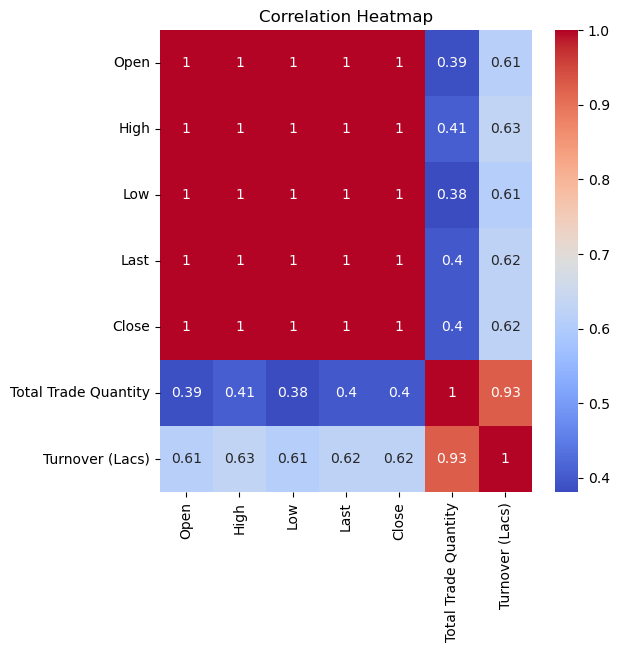

In [7]:
# **Correlation Heatmap**
plt.figure(figsize=(6, 6))
sns.heatmap(df.select_dtypes(include=['number']).corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

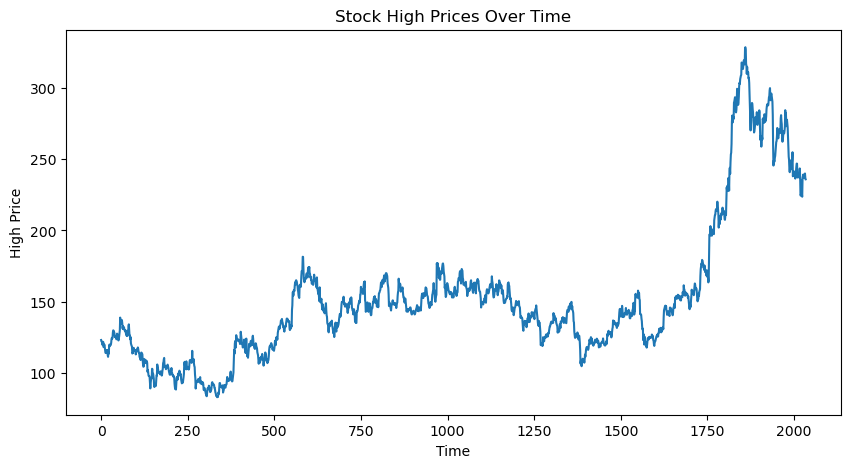

In [8]:
# **Plot 'High' column**
df_high = df.reset_index()['High']
plt.figure(figsize=(10, 5))
plt.plot(df_high)
plt.title("Stock High Prices Over Time")
plt.xlabel("Time")
plt.ylabel("High Price")
plt.show()

In [9]:
# **Apply MinMaxScaler**
scaler = MinMaxScaler(feature_range=(0, 1))
df_high = scaler.fit_transform(np.array(df_high).reshape(-1, 1))

In [10]:
# **Split the data into training and testing sets**
training_size = int(len(df_high) * 0.75)
test_size = len(df_high) - training_size
train_data, test_data = df_high[0:training_size, :], df_high[training_size:, :]

In [11]:
# **Create dataset for LSTM model**
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        dataX.append(dataset[i:(i + time_step), 0])
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [12]:
# Define time step
time_step = 100
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

In [13]:
# **Reshape input to fit LSTM model format**
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

In [14]:
# **Build LSTM Model**
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(100, 1)),
    LSTM(50, return_sequences=True),
    LSTM(50),
    Dense(1)
])
model.compile(loss='mean_squared_error', optimizer='adam')

In [15]:
# **Train the Model**
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=64, verbose=1)

Epoch 1/50

23/23 [==============================] - 7s 112ms/step - loss: 0.0065 - val_loss: 0.0270
Epoch 2/50
23/23 [==============================] - 1s 64ms/step - loss: 0.0013 - val_loss: 0.0114
Epoch 3/50
23/23 [==============================] - 2s 70ms/step - loss: 9.8180e-04 - val_loss: 0.0146
Epoch 4/50
23/23 [==============================] - 2s 68ms/step - loss: 9.3022e-04 - val_loss: 0.0127
Epoch 5/50
23/23 [==============================] - 2s 70ms/step - loss: 9.2371e-04 - val_loss: 0.0103
Epoch 6/50
23/23 [==============================] - 2s 69ms/step - loss: 8.2848e-04 - val_loss: 0.0074
Epoch 7/50
23/23 [==============================] - 2s 68ms/step - loss: 8.0856e-04 - val_loss: 0.0049
Epoch 8/50
23/23 [==============================] - 2s 74ms/step - loss: 7.3581e-04 - val_loss: 0.0071
Epoch 9/50
23/23 [==============================] - 2s 91ms/step - loss: 6.8912e-04 - val_loss: 0.0025
Epoch 10/50
23/23 [==============================] - 2s 107ms/step - loss: 6.63

In [16]:
# **Model Predictions**
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

13/13 [==============================] - 0s 16ms/step


In [17]:
# **Transform back to original scale**
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [19]:
# **Calculate RMSE**
y_train = y_train.reshape(-1, 1)  # Reshape y_train
y_test = y_test.reshape(-1, 1)  # Reshape y_test

train_rmse = math.sqrt(mean_squared_error(scaler.inverse_transform(y_train), train_predict))
test_rmse = math.sqrt(mean_squared_error(scaler.inverse_transform(y_test), test_predict))
print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)

Train RMSE: 3.806825306944975
Test RMSE: 12.241284988144859


In [20]:
# **Plot Training & Testing Predictions**
look_back = 100
trainPredictPlot = np.empty_like(df_high)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict) + look_back, :] = train_predict

testPredictPlot = np.empty_like(df_high)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict) + (look_back * 2) + 1:len(df_high) - 1, :] = test_predict

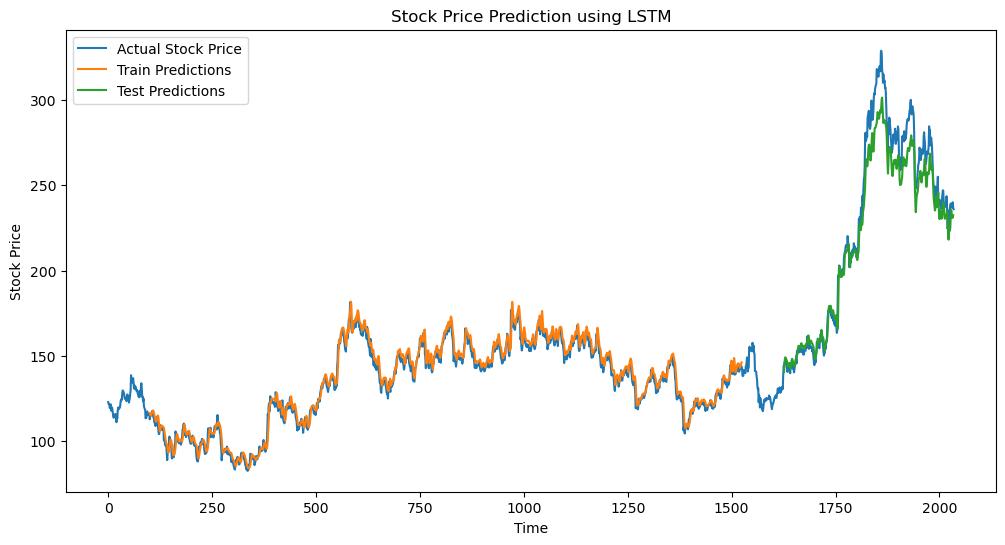

Green indicates Predicted Data
Blue indicates Complete Data
Orange indicates Train Data


In [21]:
# **Final Plot**
plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(df_high), label="Actual Stock Price")
plt.plot(trainPredictPlot, label="Train Predictions")
plt.plot(testPredictPlot, label="Test Predictions")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.title("Stock Price Prediction using LSTM")
plt.show()

print("Green indicates Predicted Data")
print("Blue indicates Complete Data")
print("Orange indicates Train Data")

In [22]:
# **Predict the Next 28 Days Stock Price**
x_input = test_data[-100:].reshape(1, -1)  # Use last 100 time steps
temp_input = list(x_input[0])

lst_output = []
n_steps = 100
nextNumberOfDays = 28

for i in range(nextNumberOfDays):
    x_input = np.array(temp_input[-n_steps:]).reshape(1, n_steps, 1)
    yhat = model.predict(x_input, verbose=0)
    temp_input.append(yhat[0][0])
    lst_output.append(yhat[0][0])


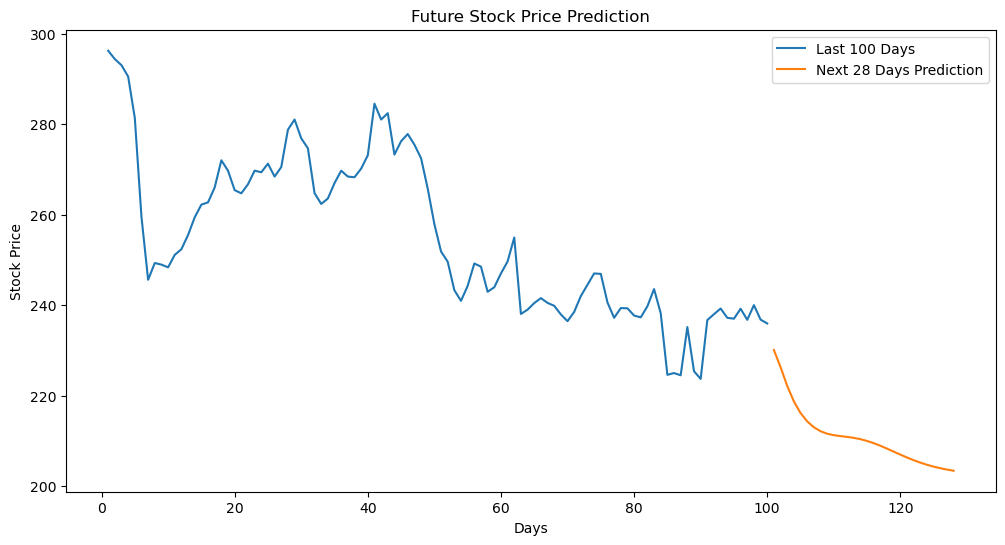

In [23]:
# **Plot Future Predictions**
day_new = np.arange(1, 101)  # Last 100 days
day_pred = np.arange(101, 129)  # Next 28 days

plt.figure(figsize=(12, 6))
plt.plot(day_new, scaler.inverse_transform(df_high[-100:]), label="Last 100 Days")
plt.plot(day_pred, scaler.inverse_transform(np.array(lst_output).reshape(-1, 1)), label="Next 28 Days Prediction")
plt.xlabel("Days")
plt.ylabel("Stock Price")
plt.legend()
plt.title("Future Stock Price Prediction")
plt.show()